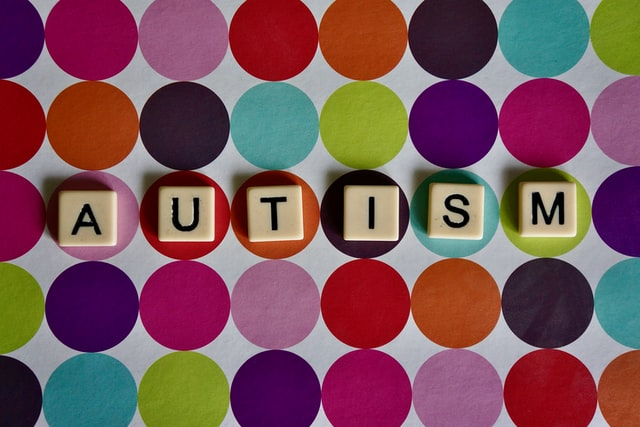

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score

#### Create train and test dataframes

In [2]:
df_train=pd.read_csv('../input/autism-prediction/Autism-prediction/train.csv',index_col='ID')
df_test=pd.read_csv('../input/autism-prediction/Autism-prediction/test.csv',index_col='ID')

#### There are 20 features, 800 training records and 200 testing records. The target is 'Class/ASD.'

In [3]:
print ("Training set shape is:", df_train.shape)
print ("Testing set shape is:", df_test.shape)

Training set shape is: (800, 21)
Testing set shape is: (200, 20)


#### Let's examine the first few rows

In [4]:
df_train.head(5).T

ID,1,2,3,4,5
A1_Score,1,0,1,0,0
A2_Score,0,0,1,0,0
A3_Score,1,0,1,0,0
A4_Score,1,0,1,1,0
A5_Score,1,0,1,0,1
A6_Score,1,0,1,0,0
A7_Score,0,0,0,0,0
A8_Score,1,0,0,0,0
A9_Score,1,0,1,0,1
A10_Score,1,1,1,0,1



#### Several features can easily be converted to binary numeric using Label Encoder

In [5]:
features = ['gender','jaundice','austim','used_app_before']
for feature in features:
    df_train[feature]= LabelEncoder().fit_transform(df_train[feature])
    df_test[feature]= LabelEncoder().fit_transform(df_test[feature])

#### Let's simplify the name of the target

In [6]:
df_train.rename(columns = {'Class/ASD':'ASD'}, inplace = True)
df_test.rename(columns = {'Class/ASD':'ASD'}, inplace = True)

#### Note that less than one quarter of cases have autism.

In [7]:
print(df_train.ASD.value_counts())

0    615
1    185
Name: ASD, dtype: int64


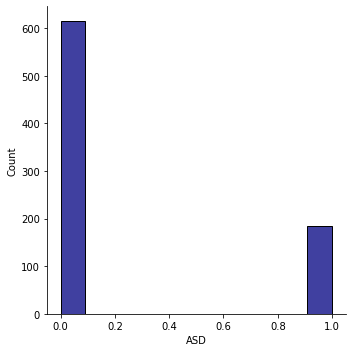

In [8]:
# df_train.ASD.hist
sns.displot(df_train.ASD, color = 'navy')

#### We can safely drop the age_desc feature as all values are identical on both training and test sets

In [9]:
print('Training set values for age_desc:',df_train.age_desc.value_counts())
print('Test set values for age_desc:', df_test.age_desc.value_counts())
df_train = df_train.drop(columns = ['age_desc'])
df_test = df_test.drop(columns = ['age_desc'])

Training set values for age_desc: 18 and more    800
Name: age_desc, dtype: int64
Test set values for age_desc: 18 and more    200
Name: age_desc, dtype: int64


#### Country of residence is problematic so let's drop and see whether a good model can be produced without it

In [10]:
print("Number of countries in training set:",len(df_train.contry_of_res.unique()))
print("Number of countries in training set:",len(df_test.contry_of_res.unique()))
df_train = df_train.drop(columns = ['contry_of_res'])
df_test = df_test.drop(columns = ['contry_of_res'])

Number of countries in training set: 61
Number of countries in training set: 44


#### More than half of the 'White-Europeans' in this sample are diagnosed with autism. Why?

In [11]:
print(df_train.groupby('ethnicity')['ASD'].value_counts())

ethnicity        ASD
?                0      136
                 1       15
Asian            0      117
                 1       17
Black            0       37
                 1        8
Hispanic         0       11
                 1        5
Latino           0       29
                 1       15
Middle Eastern   0      108
                 1        8
Others           0       19
                 1        5
Pasifika         0       17
                 1        1
South Asian      0       34
                 1        1
Turkish          0        3
                 1        1
White-European   1      108
                 0      103
others           0        1
                 1        1
Name: ASD, dtype: int64


#### The following code creates a separate feature to reflect this

In [12]:
df_temp = pd.get_dummies(df_train.ethnicity)
df_train['White-European'] = df_temp['White-European']
df_train = df_train.drop(columns = ['ethnicity'])

In [13]:
df_temp = pd.get_dummies(df_test.ethnicity)
df_test['White-European'] = df_temp['White-European']
df_test = df_test.drop(columns = ['ethnicity'])

#### Let's look at the 'relation' feature. Not obvious there is a close link to the target but let's retain it for now.

In [14]:
print(df_train.groupby('relation')['ASD'].value_counts(normalize = True))

relation                  ASD
?                         0      0.974026
                          1      0.025974
Health care professional  0      1.000000
Others                    0      0.857143
                          1      0.142857
Parent                    0      0.653061
                          1      0.346939
Relative                  0      0.860465
                          1      0.139535
Self                      0      0.742301
                          1      0.257699
Name: ASD, dtype: float64


In [15]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

#### Let's visualise the features

array([[<AxesSubplot:title={'center':'A1_Score'}>,
        <AxesSubplot:title={'center':'A2_Score'}>,
        <AxesSubplot:title={'center':'A3_Score'}>,
        <AxesSubplot:title={'center':'A4_Score'}>,
        <AxesSubplot:title={'center':'A5_Score'}>],
       [<AxesSubplot:title={'center':'A6_Score'}>,
        <AxesSubplot:title={'center':'A7_Score'}>,
        <AxesSubplot:title={'center':'A8_Score'}>,
        <AxesSubplot:title={'center':'A9_Score'}>,
        <AxesSubplot:title={'center':'A10_Score'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'jaundice'}>,
        <AxesSubplot:title={'center':'austim'}>,
        <AxesSubplot:title={'center':'used_app_before'}>],
       [<AxesSubplot:title={'center':'result'}>,
        <AxesSubplot:title={'center':'White-European'}>,
        <AxesSubplot:title={'center':'relation_?'}>,
        <AxesSubplot:title={'center':'relation_Health care professional'}>

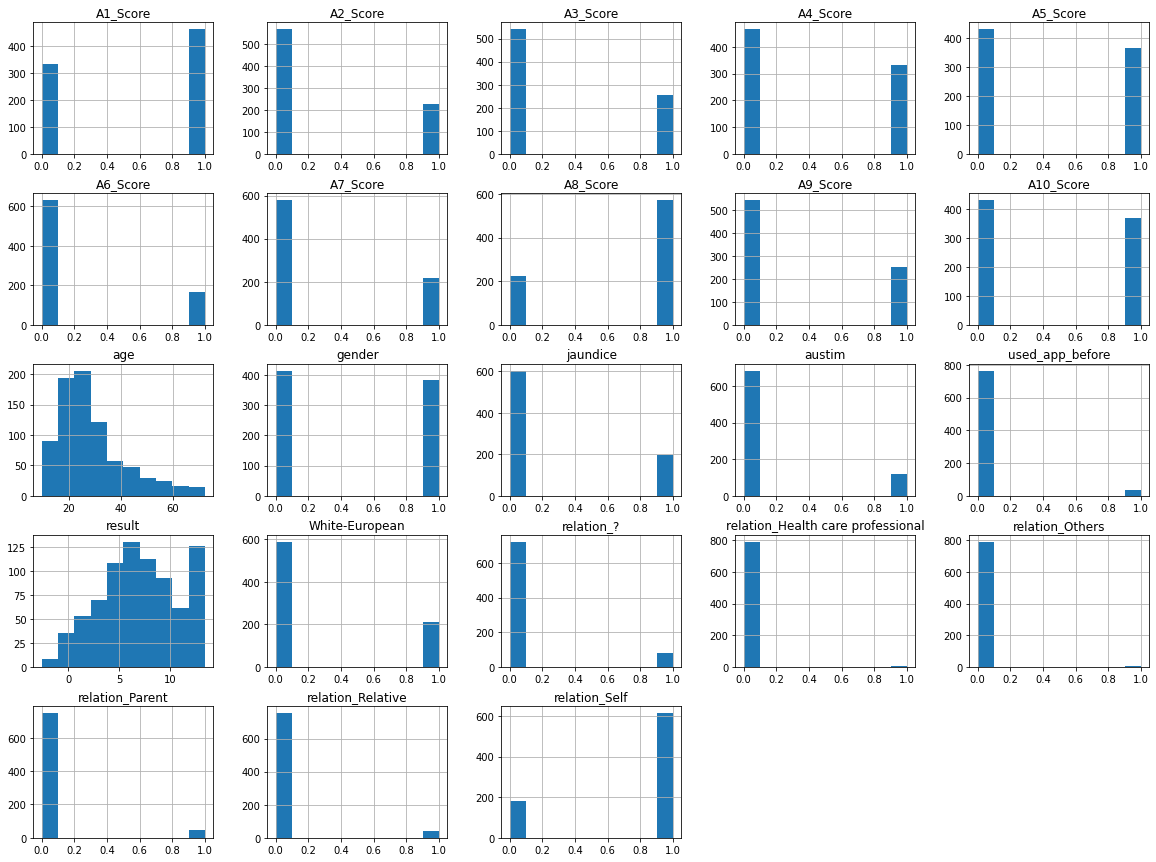

In [16]:
df_train.drop(columns = 'ASD').hist(figsize=(20,15))

#### The 'A' scores form part of a single Autism Spectrum Quotient test (AQ-10). They are meant to be diagnostic when added together so let's do this and create a new feature called 'A_Score.'

In [17]:
temp = df_train.iloc[:,0:10]
A = [sum(temp.iloc[n]) for n in range(800)]
df_train['A_Score'] = A
df_train = df_train.drop(columns = temp.columns)

In [18]:
temp1 = df_test.iloc[:,0:10]
A1 = [sum(temp1.iloc[n]) for n in range(200)]
df_test['A_Score'] = A1
df_test
df_test = df_test.drop(columns = temp.columns)

#### The new feature has better correlation with the target than individual A-score features

In [19]:
df_train.corr().ASD.sort_values(ascending = False)

ASD                                  1.000000
A_Score                              0.661272
result                               0.496165
White-European                       0.398323
austim                               0.377079
jaundice                             0.190769
age                                  0.146376
relation_Self                        0.115182
relation_Parent                      0.070087
used_app_before                     -0.015853
relation_Others                     -0.019697
relation_Health care professional   -0.051530
relation_Relative                   -0.051843
gender                              -0.124789
relation_?                          -0.158884
Name: ASD, dtype: float64

#### Logistic Regression assumes that features are not correlated closely with each other so let's check

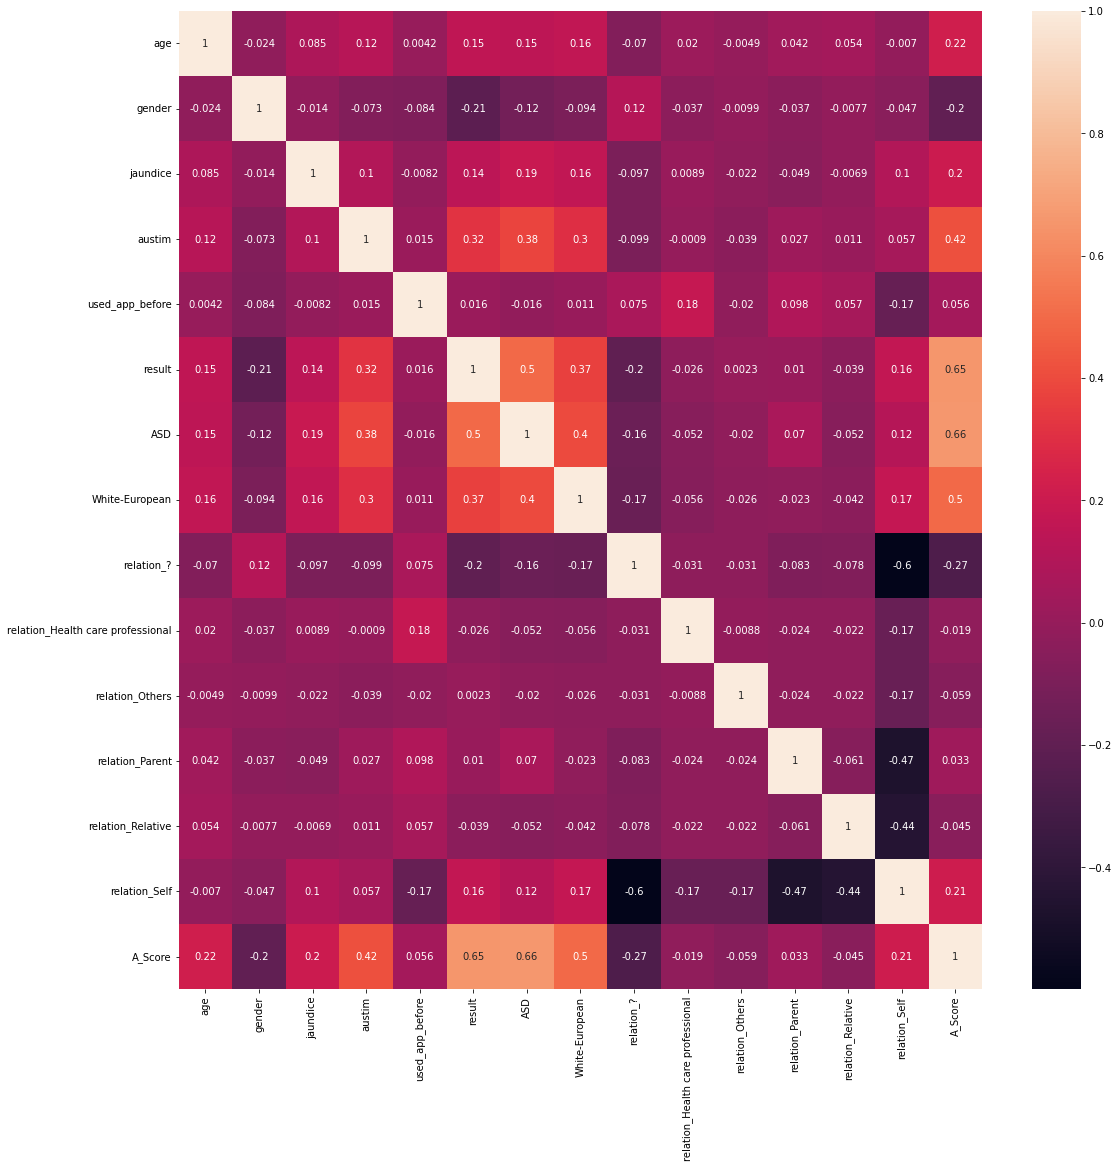

In [20]:
plt.figure(1 , figsize = (18 , 18))
cor = sns.heatmap(df_train.corr(), annot = True)

#### 'A_Score' and 'result' are correlated (> .5) so let's drop the latter

In [21]:
df_train = df_train.drop(columns = ['result'])
df_test = df_test.drop(columns = ['result'])

#### Let's use the best performing features for the model

In [22]:
features = ["A_Score","White-European","austim"]

#### Let's use cross validation to see how well these features perform

In [23]:
y = df_train['ASD']
X = df_train[features]
df_test = df_test[features]

In [24]:
clf = LogisticRegression()
clf.fit(X,y)

LogisticRegression()

In [25]:
print(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))
print(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

[0.825  0.8375 0.825  0.9    0.875  0.8875 0.9125 0.9    0.875  0.8625]
0.8700000000000001


#### A sample score and confusion matrix

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y)
clf.fit(X_train, y_train)
clf.score(X_valid,y_valid)

0.85

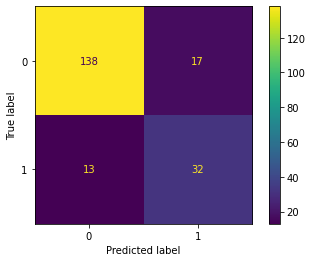

In [27]:
predictions = clf.predict(X_valid)
cm = confusion_matrix(y_valid, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

#### Refit the model using all the data

In [28]:
clf.fit(X,y)

LogisticRegression()

#### Create the submission file

In [29]:
submission =pd.read_csv('../input/autism-prediction/Autism-prediction/sample_submission.csv', index_col='ID')
submission['Class/ASD'] = clf.predict(df_test)
submission.to_csv('submission.csv')
